# Exploratory Data Analysis

## Import of Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score

from scipy import stats

from pycaret.classification import ClassificationExperiment
from pycaret.clustering import ClusteringExperiment

In [2]:
cwd = Path().cwd()
data = cwd / 'Sleep-Health-Lifestyle-Dataset'
data_csv = list(data.iterdir())[0]
df = pd.read_csv(data_csv)

Checking if the data has missing values. Upon checking, only the target has missing values. These missing values will be filled up with "No Sleep Disorder".

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [4]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No Sleep Disorder')

In [5]:
df['Sleep Disorder'].value_counts()

Sleep Disorder
No Sleep Disorder    219
Sleep Apnea           78
Insomnia              77
Name: count, dtype: int64

In [6]:
df.sample(10, random_state=42)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
329,330,Female,53,Engineer,8.5,9,30,3,Normal,125/80,65,5000,No Sleep Disorder
33,34,Male,31,Doctor,6.1,6,30,8,Normal,125/80,72,5000,No Sleep Disorder
15,16,Male,29,Doctor,6.0,6,30,8,Normal,120/80,70,8000,No Sleep Disorder
325,326,Female,53,Engineer,8.5,9,30,3,Normal,125/80,65,5000,No Sleep Disorder
57,58,Male,32,Doctor,6.0,6,30,8,Normal,125/80,72,5000,No Sleep Disorder
239,240,Male,44,Salesperson,6.4,6,45,7,Overweight,130/85,72,6000,Insomnia
76,77,Male,33,Doctor,6.0,6,30,8,Normal,125/80,72,5000,No Sleep Disorder
119,120,Female,37,Accountant,7.2,8,60,4,Normal,115/75,68,7000,No Sleep Disorder
332,333,Female,54,Engineer,8.4,9,30,3,Normal,125/80,65,5000,No Sleep Disorder
126,127,Male,38,Lawyer,7.3,8,60,5,Normal,130/85,68,8000,No Sleep Disorder


Blood pressure is defined by both systolic and diastolic pressure, therefore it is valid to split it into two columns.

In [7]:
df[['bp_systolic', 'bp_diastolic']] = (
    df['Blood Pressure']
    .str
    .split('/', expand=True)
    .astype(int)
)

It makes sense to drop Person ID since this should not impact prediction if a person has sleeping disorder or not. Additionally, since we have already transformed the Blood Pressure column into two, namely bp_systolic and bp_diastolic, the original feature shall be dropped.

In [8]:
df = df.drop(columns=['Person ID', 'Blood Pressure'])

An overview of the statistics of the transformed data.

In [9]:
df.describe(include='all')

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,bp_systolic,bp_diastolic
count,374,374.000000,374,374.000000,374.000000,374.000000,374.000000,374,374.000000,374.000000,374,374.000000,374.000000
unique,2,NaN,11,NaN,NaN,NaN,NaN,4,NaN,NaN,3,NaN,NaN
top,Male,NaN,Nurse,NaN,NaN,NaN,NaN,Normal,NaN,NaN,No Sleep Disorder,NaN,NaN
freq,189,NaN,73,NaN,NaN,NaN,NaN,195,NaN,NaN,219,NaN,NaN
mean,NaN,42.184492,NaN,7.132086,7.312834,59.171123,5.385027,NaN,70.165775,6816.844920,NaN,128.553476,84.649733
std,NaN,8.673133,NaN,0.795657,1.196956,20.830804,1.774526,NaN,4.135676,1617.915679,NaN,7.748118,6.161611
min,NaN,27.000000,NaN,5.800000,4.000000,30.000000,3.000000,NaN,65.000000,3000.000000,NaN,115.000000,75.000000
25%,NaN,35.250000,NaN,6.400000,6.000000,45.000000,4.000000,NaN,68.000000,5600.000000,NaN,125.000000,80.000000
50%,NaN,43.000000,NaN,7.200000,7.000000,60.000000,5.000000,NaN,70.000000,7000.000000,NaN,130.000000,85.000000
75%,NaN,50.000000,NaN,7.800000,8.000000,75.000000,7.000000,NaN,72.000000,8000.000000,NaN,135.000000,90.000000


## Class Distribution

Visualizing the distribution of the different features. The distributions are shown for each feature for the following:

1. Whole dataset,
2. No Sleeping Disorder,
3. Sleep Apnea, and 
4. Insomnia

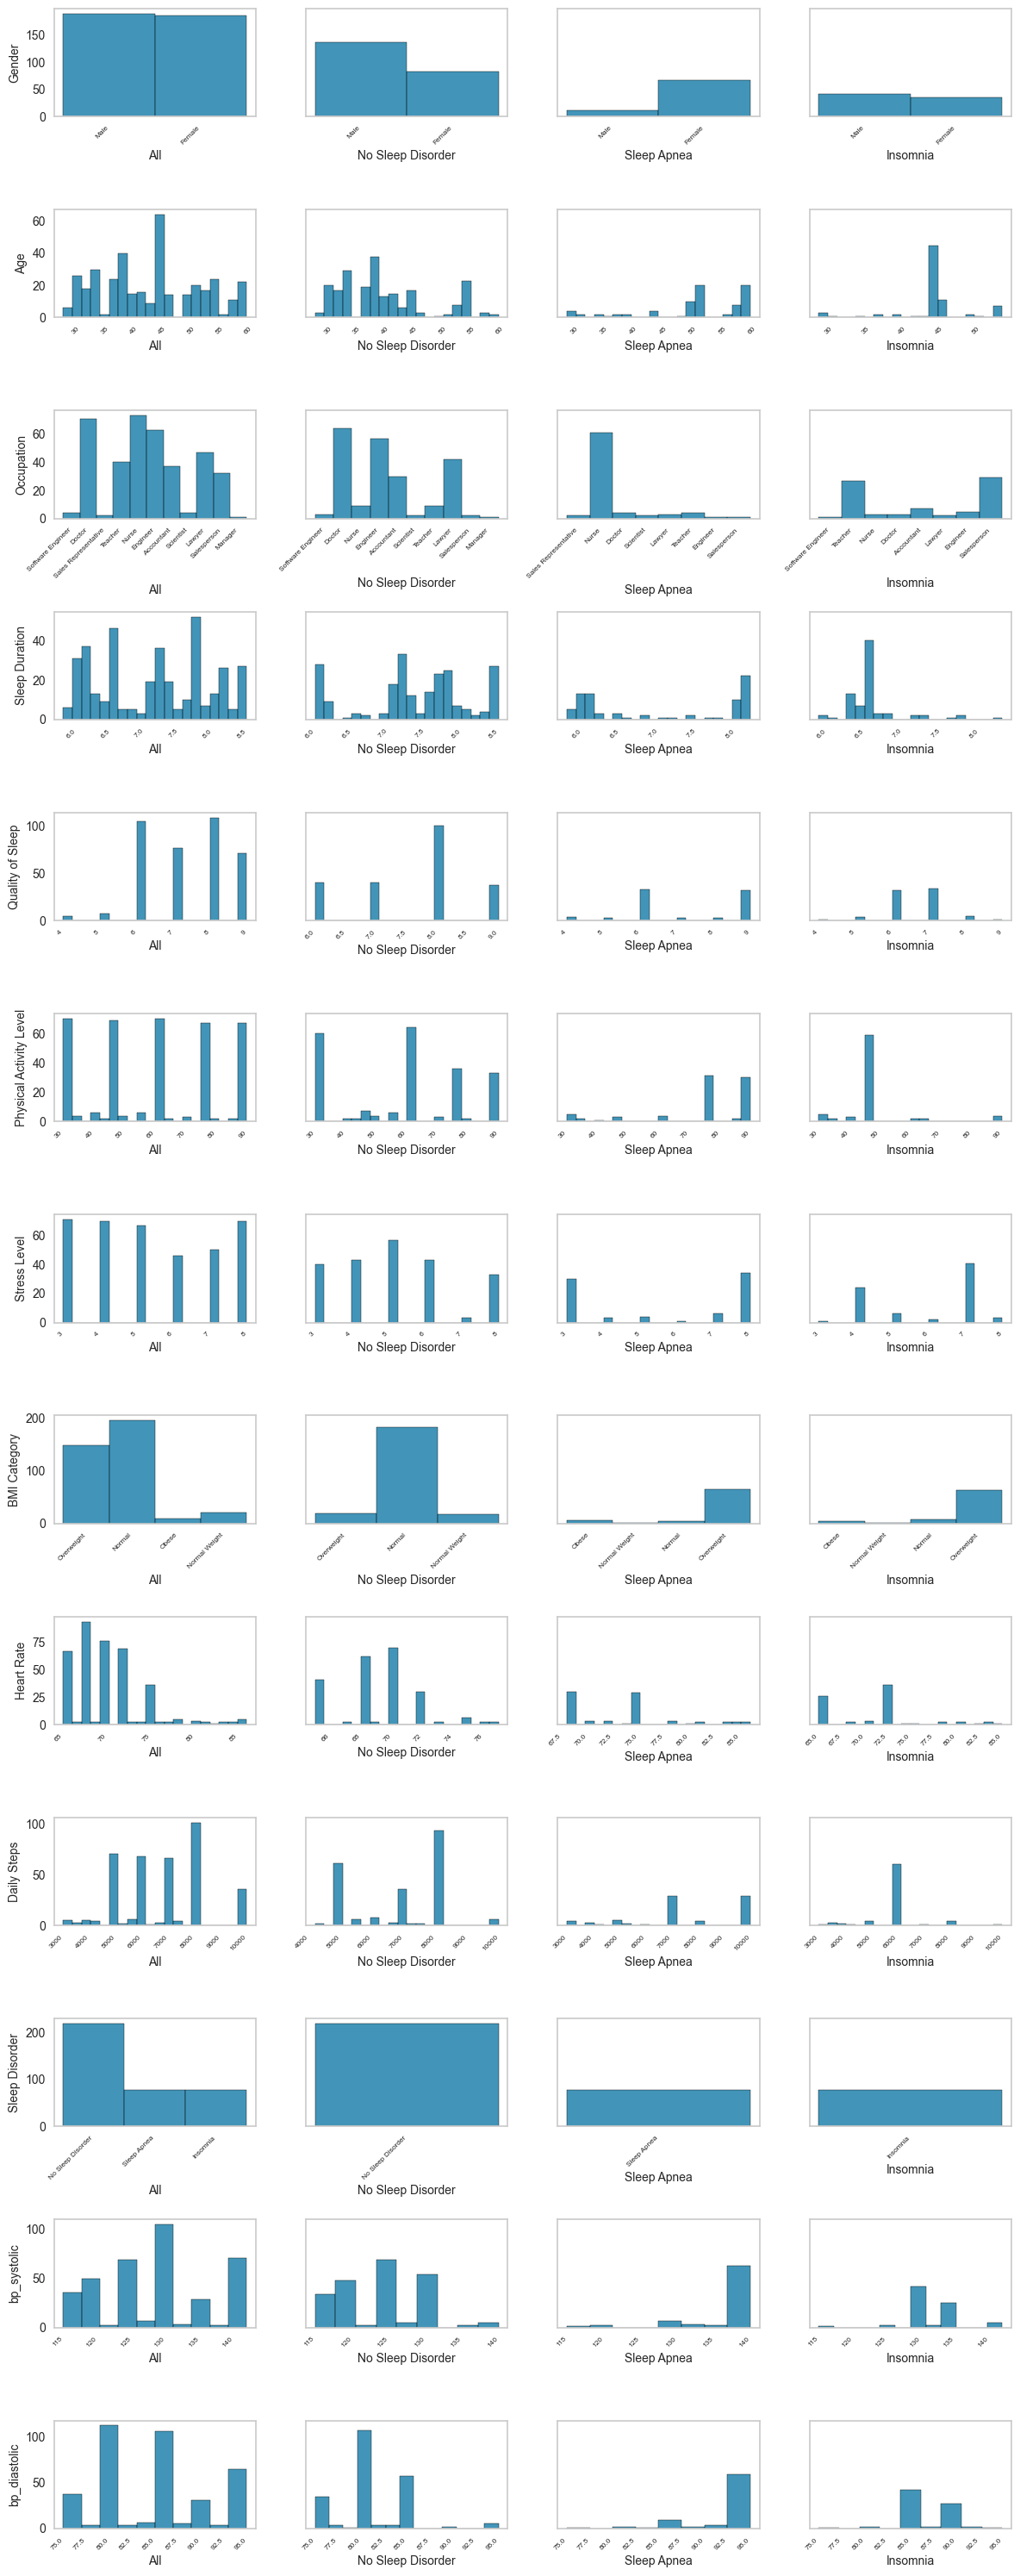

In [10]:
sleep_disorders = ['All'] + df['Sleep Disorder'].unique().tolist()
dataframes = [df] + [df[df['Sleep Disorder'] == x] for x in sleep_disorders[1:]]

x, axes = plt.subplots(nrows=len(df.columns), ncols=4, figsize=(12, 30), sharey='row')
axes = axes.flatten()
col_multiplied = np.array([[x, x, x, x] for x in df.columns]).reshape(-1)
for col, (index, ax)in zip(col_multiplied, enumerate(axes)):
    if (index + 1) % 4 == 1:
        df_use = dataframes[0]
        name = sleep_disorders[0]
    if (index + 1) % 4 == 2:
        df_use = dataframes[1]
        name = sleep_disorders[1]
    if (index + 1) % 4 == 3:
        df_use = dataframes[2]
        name = sleep_disorders[2]
    if (index + 1) % 4 == 0:
        df_use = dataframes[3]
        name = sleep_disorders[3]

    if (df_use[col].dtype == 'int64') or (df_use[col].dtype == 'float64'):
        bins = 20
    else:
        bins = 'auto'

    sns.histplot(df_use, x=col, ax=ax, bins=bins)
    ax.set_ylabel(col, fontsize=10)
    ax.set_xlabel(name, fontsize=10)
    ax.tick_params(axis='x', labelrotation=45, labelsize=6)
    ax.grid(False)

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

plt.tight_layout()  

<Axes: >

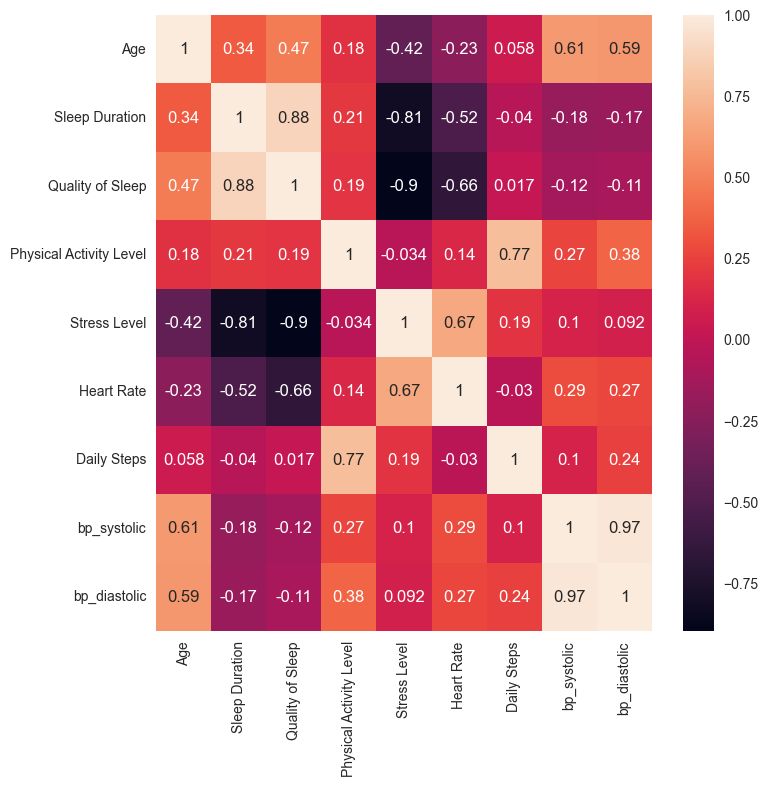

In [11]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True)

Data will be split into features and target where the target is the Sleep Disorder {No Sleep Disorder, Insomnia, Sleep Apnea}.

Additionally, we will randomly split our train and test data in the ratio 6:4.

In [12]:
X = df.copy().drop(columns=['Sleep Disorder'])
y = df['Sleep Disorder'].copy()

display(X.sample(10, random_state=42))
display(y.sample(10, random_state=42))

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,bp_systolic,bp_diastolic
329,Female,53,Engineer,8.5,9,30,3,Normal,65,5000,125,80
33,Male,31,Doctor,6.1,6,30,8,Normal,72,5000,125,80
15,Male,29,Doctor,6.0,6,30,8,Normal,70,8000,120,80
325,Female,53,Engineer,8.5,9,30,3,Normal,65,5000,125,80
57,Male,32,Doctor,6.0,6,30,8,Normal,72,5000,125,80
239,Male,44,Salesperson,6.4,6,45,7,Overweight,72,6000,130,85
76,Male,33,Doctor,6.0,6,30,8,Normal,72,5000,125,80
119,Female,37,Accountant,7.2,8,60,4,Normal,68,7000,115,75
332,Female,54,Engineer,8.4,9,30,3,Normal,65,5000,125,80
126,Male,38,Lawyer,7.3,8,60,5,Normal,68,8000,130,85


329    No Sleep Disorder
33     No Sleep Disorder
15     No Sleep Disorder
325    No Sleep Disorder
57     No Sleep Disorder
239             Insomnia
76     No Sleep Disorder
119    No Sleep Disorder
332    No Sleep Disorder
126    No Sleep Disorder
Name: Sleep Disorder, dtype: object

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.60, 
    stratify=y, 
    random_state=42
)

# Baseline Model: Logistic Regression

We will first define a baseline model where no tuning of hyperparameters will be performed. Preprocessing of data is simply applying a OneHotEncoder for the categorical data and StandardScaler for the numerical data.

## Train

In [69]:
object_col = [col for col in df.columns if df[col].dtype == 'object' and col != 'Sleep Disorder']
int_col = [col for col in df.columns if df[col].dtype == 'int64' or df[col].dtype == 'int32']
float_col = [col for col in df.columns if df[col].dtype == 'float64']

In [70]:
onehotencoder = ColumnTransformer(
    [
        (
            'onehotencoder', 
            OneHotEncoder(
                handle_unknown='infrequent_if_exist', 
                sparse_output=False,
                min_frequency=0.02
            ), 
            object_col
        ),
    ],
    remainder='passthrough'
).set_output(transform='pandas')

baseline = Pipeline([
    ('onehotencoder', onehotencoder),
    ('scaler', StandardScaler().set_output(transform='pandas')),
    ('model', LogisticRegression(random_state=42))
])

baseline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                feature_name_combiner='concat',
                                                                handle_unknown='infrequent_if_exist',
                                                                max_categories=None,
                                                                min_frequency=0...
                                   verbose_feature_names_out=True)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

## Metrics

In [71]:
baseline_accuracy = baseline.score(X_test, y_test)

In [72]:
pd.DataFrame(
    classification_report(
        y_test, 
        baseline.predict(X_test), 
        output_dict=True
    )
)

,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.962963,0.955056,0.823529,0.926667,0.913850,0.929508
recall,0.838710,0.965909,0.903226,0.926667,0.902615,0.926667
f1-score,0.896552,0.960452,0.861538,0.926667,0.906181,0.926804
support,31.000000,88.000000,31.000000,0.926667,150.000000,150.000000


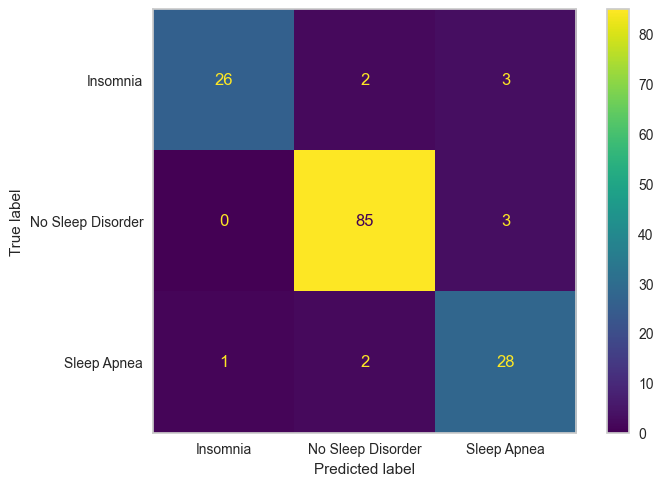

In [73]:
ConfusionMatrixDisplay.from_estimator(baseline, X_test, y_test)
plt.grid(visible=False);

Based on the results of the baseline model for the test data, we are seeing an accuracy of 92.67% with 11 misclassified out of the 150 test data.

# Tuned Model: Optimized Logistic Regression

## Train

In [74]:
onehotencoder = ColumnTransformer(
    [
        (
            'onehotencoder', 
            OneHotEncoder(
                handle_unknown='infrequent_if_exist', 
                sparse_output=False,
                min_frequency=0.02
            ), 
            object_col
        ),
    ],
    remainder='passthrough'
).set_output(transform='pandas')

pipeline = Pipeline([
    ('onehotencoder', onehotencoder),
    ('scaler', StandardScaler().set_output(transform='pandas')),
    ('model', LogisticRegression(random_state=42))
])

param_distributions = {
    'model__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'model__C': stats.loguniform(0.01, 100),
    'model__fit_intercept': [True, False],
    'model__intercept_scaling': stats.uniform(0.001, 0.999),
    'model__solver': ['saga', 'lbfgs'],
    'model__class_weight': [None, 'balanced'],
    'model__max_iter': [1000],
    'model__l1_ratio': stats.uniform(0.001, 0.999),   
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rscv = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='accuracy',
    cv=cv,
    verbose=0,
    random_state=42,
    return_train_score=True,
    n_jobs=-1
)

rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(categories='auto',
                                                                                             drop=None,
                                                                                             dtype=<class 'numpy.float64...
                                        'model__intercept_scaling': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000218905352D0>,
                                        'model__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000218AA22C550>,
                                        'model__max_iter': [1000],
                                        'model__penalty': [None, 'l1', 'l2',
                                                           'elasticnet'],
                                        'model__solver': ['saga', 'lbfgs']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=True, scoring='accuracy', verbose=0)

In [75]:
rscv.best_params_

{'model__C': 0.31489116479568624,
 'model__class_weight': None,
 'model__fit_intercept': True,
 'model__intercept_scaling': 0.7322619478695936,
 'model__l1_ratio': 0.5990598257128396,
 'model__max_iter': 1000,
 'model__penalty': 'l2',
 'model__solver': 'lbfgs'}

## Metrics

In [76]:
tuned_accuracy = rscv.best_estimator_.score(X_test, y_test)

In [77]:
pd.DataFrame(
    classification_report(
        y_test, 
        rscv.best_estimator_.predict(X_test), 
        output_dict=True
    )
)

,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.931034,0.954545,0.848485,0.926667,0.911355,0.927767
recall,0.870968,0.954545,0.903226,0.926667,0.909580,0.926667
f1-score,0.900000,0.954545,0.875000,0.926667,0.909848,0.926833
support,31.000000,88.000000,31.000000,0.926667,150.000000,150.000000


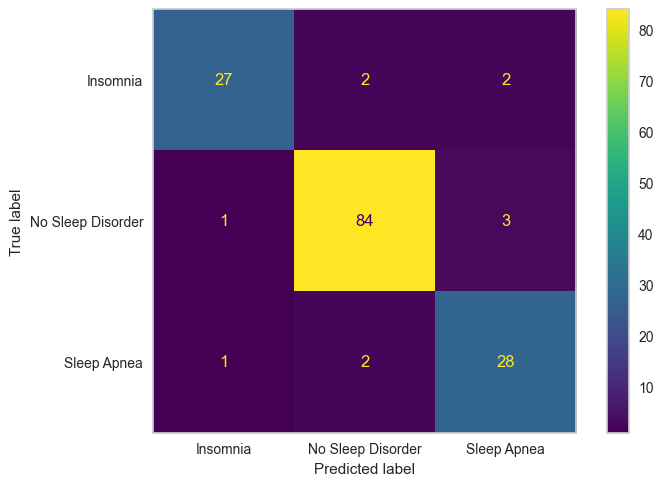

In [78]:
ConfusionMatrixDisplay.from_estimator(rscv.best_estimator_, X_test, y_test)
plt.grid(visible=False);

We have an optimized model where RandomizedSearchCV was used to search for better hyperparameters. The model has maintained accuracy over the test data, having an accuracy of 92.67% with misclassifying 11 out of 150.

# Pycaret Classification

In [ ]:
s = ClassificationExperiment()
s.setup(
    df,
    target='Sleep Disorder',
    imputation_type=None,
    session_id=42,
    train_size=0.6,
    rare_to_value=0.02,
    fold=5,
    normalize=True,
)

,Description,Value
0,Session id,42
1,Target,Sleep Disorder
2,Target type,Multiclass
3,Target mapping,"Insomnia: 0, No Sleep Disorder: 1, Sleep Apnea: 2"
4,Original data shape,"(374, 13)"
5,Transformed data shape,"(374, 23)"
6,Transformed train set shape,"(224, 23)"
7,Transformed test set shape,"(150, 23)"
8,Numeric features,9
9,Categorical features,3


We will select the top 3 models (other than a logistic regression model) and tune them.

## Compare Default Models

In [ ]:
model_1, _, model_2, model_3 = s.compare_models(n_select=4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8930,0.9132,0.8930,0.9052,0.8940,0.8147,0.8190,0.0720
lr,Logistic Regression,0.8886,0.0000,0.8886,0.8937,0.8886,0.8048,0.8073,0.5280
ridge,Ridge Classifier,0.8886,0.0000,0.8886,0.8935,0.8883,0.8043,0.8072,0.0200
xgboost,Extreme Gradient Boosting,0.8841,0.9095,0.8841,0.8912,0.8843,0.7992,0.8025,0.0360
catboost,CatBoost Classifier,0.8841,0.9180,0.8841,0.8943,0.8849,0.8002,0.8043,0.3980
svm,SVM - Linear Kernel,0.8798,0.0000,0.8798,0.8884,0.8783,0.7870,0.7918,0.0240
lda,Linear Discriminant Analysis,0.8796,0.0000,0.8796,0.8894,0.8807,0.7907,0.7939,0.0200
gbc,Gradient Boosting Classifier,0.8753,0.0000,0.8753,0.8851,0.8760,0.7848,0.7888,0.0740
rf,Random Forest Classifier,0.8708,0.9224,0.8708,0.8802,0.8717,0.7780,0.7818,0.0580
knn,K Neighbors Classifier,0.8707,0.9133,0.8707,0.8751,0.8682,0.7719,0.7760,0.5340


We will select Light Gradient Boosting Machine as model 1, Ridge Classifier as model 2, and CatBoost Classifier as model 3.

In [27]:
X_train_transformed, y_train_transformed = s.X_train_transformed, s.y_train_transformed
X_test_transformed, y_test_transformed = s.X_test_transformed, s.y_test_transformed

## Model 1: Light Gradient Boosting Machine

In [28]:
model_1_tuned = s.tune_model(model_1, n_iter=500)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9333,0.9309,0.9333,0.9400,0.9317,0.8750,0.8821
1,0.8889,0.8736,0.8889,0.8981,0.8864,0.8021,0.8075
2,0.8667,0.9589,0.8667,0.8865,0.8688,0.7778,0.7865
3,0.8889,0.9214,0.8889,0.8956,0.8912,0.8075,0.8082
4,0.9545,0.9397,0.9545,0.9545,0.9545,0.9199,0.9199
Mean,0.9065,0.9249,0.9065,0.9149,0.9065,0.8365,0.8408
Std,0.0324,0.0285,0.0324,0.0271,0.0316,0.0527,0.0511


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [29]:
model_1_tuned_accuracy = model_1_tuned.score(X_test_transformed, y_test_transformed)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [30]:
pd.DataFrame(
    classification_report(
        y_test_transformed, 
        model_1_tuned.predict(X_test_transformed), 
        output_dict=True,
        target_names=s.pipeline['label_encoding'].inverse_transform(model_1_tuned.classes_)
    )
)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.857143,0.934783,0.833333,0.9,0.875086,0.897771
recall,0.774194,0.977273,0.806452,0.9,0.852639,0.900000
f1-score,0.813559,0.955556,0.819672,0.9,0.862929,0.898127
support,31.000000,88.000000,31.000000,0.9,150.000000,150.000000


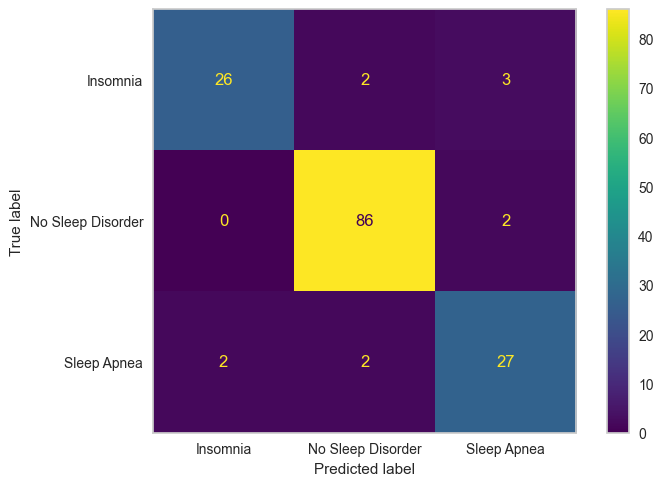

In [31]:
ConfusionMatrixDisplay.from_estimator(
    model_1, 
    X_test_transformed, 
    y_test_transformed, 
    display_labels=s.pipeline['label_encoding'].inverse_transform(model_1_tuned.classes_)
)
plt.grid(visible=False);

## Model 2: Ridge Classifier

In [32]:
model_2_tuned = s.tune_model(model_2, n_iter=500)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9111,0.0000,0.9111,0.9086,0.9080,0.8361,0.8389
1,0.8889,0.0000,0.8889,0.8889,0.8882,0.8047,0.8055
2,0.8889,0.0000,0.8889,0.9043,0.8912,0.8150,0.8215
3,0.8667,0.0000,0.8667,0.8691,0.8671,0.7656,0.7664
4,0.9318,0.0000,0.9318,0.9307,0.9305,0.8779,0.8788
Mean,0.8975,0.0000,0.8975,0.9003,0.8970,0.8198,0.8222
Std,0.0222,0.0000,0.0222,0.0205,0.0212,0.0369,0.0371


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [33]:
model_2_tuned_accuracy = model_2_tuned.score(X_test_transformed, y_test_transformed)

In [34]:
pd.DataFrame(
    classification_report(
        y_test_transformed, 
        model_2_tuned.predict(X_test_transformed), 
        output_dict=True,
        target_names=s.pipeline['label_encoding'].inverse_transform(model_2_tuned.classes_)
    )
)

,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.925926,0.942529,0.750000,0.893333,0.872818,0.899308
recall,0.806452,0.931818,0.870968,0.893333,0.869746,0.893333
f1-score,0.862069,0.937143,0.805970,0.893333,0.868394,0.894519
support,31.000000,88.000000,31.000000,0.893333,150.000000,150.000000


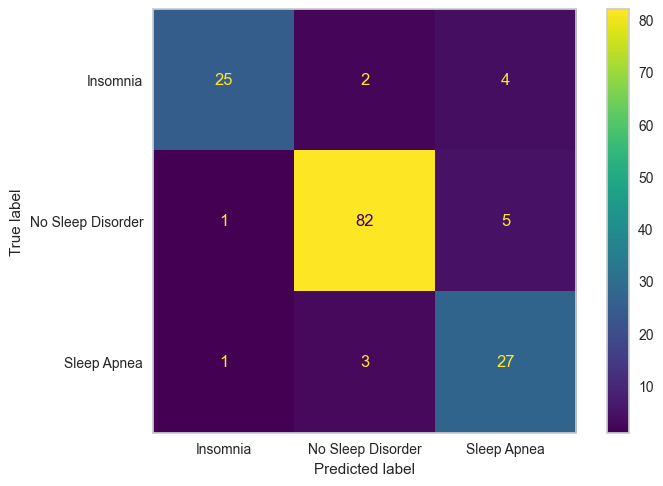

In [35]:
ConfusionMatrixDisplay.from_estimator(
    model_2_tuned, 
    X_test_transformed, 
    y_test_transformed, 
    display_labels=s.pipeline['label_encoding'].inverse_transform(model_2_tuned.classes_)
)
plt.grid(visible=False);

## Model 3: CatBoost Classifier

In [36]:
model_3_tuned = s.tune_model(model_3, n_iter=500)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9333,0.9494,0.9333,0.9364,0.9313,0.8770,0.8808
1,0.9111,0.8815,0.9111,0.9159,0.9103,0.8415,0.8450
2,0.8667,0.9514,0.8667,0.8865,0.8688,0.7778,0.7865
3,0.8889,0.9097,0.8889,0.8956,0.8912,0.8075,0.8082
4,0.9545,0.9436,0.9545,0.9545,0.9545,0.9199,0.9199
Mean,0.9109,0.9271,0.9109,0.9178,0.9112,0.8448,0.8481
Std,0.0311,0.0273,0.0311,0.0252,0.0300,0.0501,0.0482


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [37]:
model_3_tuned_accuracy = model_3_tuned.score(X_test_transformed, y_test_transformed)

In [38]:
pd.DataFrame(
    classification_report(
        y_test_transformed, 
        model_3_tuned.predict(X_test_transformed), 
        output_dict=True,
        target_names=s.pipeline['label_encoding'].inverse_transform(model_3_tuned.classes_)
    )
)

,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.931034,0.955556,0.870968,0.933333,0.919186,0.933006
recall,0.870968,0.977273,0.870968,0.933333,0.906403,0.933333
f1-score,0.900000,0.966292,0.870968,0.933333,0.912420,0.932891
support,31.000000,88.000000,31.000000,0.933333,150.000000,150.000000


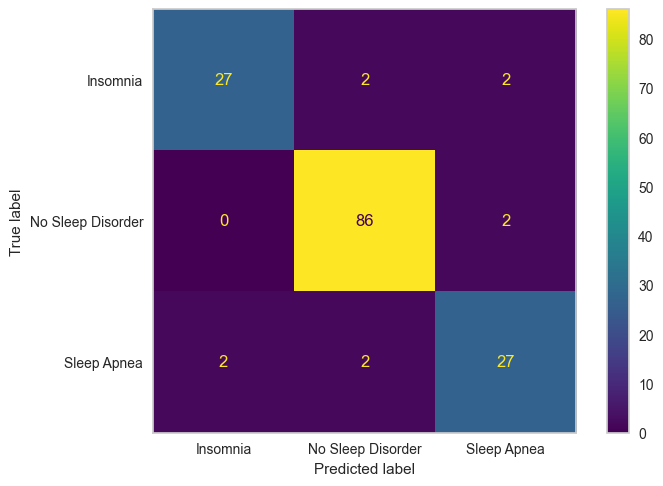

In [39]:
ConfusionMatrixDisplay.from_estimator(
    model_3_tuned, 
    X_test_transformed, 
    y_test_transformed, 
    display_labels=s.pipeline['label_encoding'].inverse_transform(model_3_tuned.classes_)
)
plt.grid(visible=False);

## Model 4: Stacked Model

In [40]:
model_stacked_tuned = s.stack_models([model_1_tuned, model_2_tuned, model_3_tuned])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9333,0.0000,0.9333,0.9364,0.9313,0.8770,0.8808
1,0.8667,0.0000,0.8667,0.8813,0.8663,0.7660,0.7708
2,0.8889,0.0000,0.8889,0.9043,0.8912,0.8150,0.8215
3,0.8444,0.0000,0.8444,0.8558,0.8471,0.7268,0.7288
4,0.9318,0.0000,0.9318,0.9312,0.9304,0.8798,0.8806
Mean,0.8930,0.0000,0.8930,0.9018,0.8933,0.8129,0.8165
Std,0.0352,0.0000,0.0352,0.0304,0.0337,0.0603,0.0601


In [41]:
model_stacked_tuned_accuracy = model_stacked_tuned.score(X_test_transformed, y_test_transformed)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [42]:
pd.DataFrame(
    classification_report(
        y_test_transformed, 
        model_stacked_tuned.predict(X_test_transformed), 
        output_dict=True,
        target_names=s.pipeline['label_encoding'].inverse_transform(model_stacked_tuned.classes_)
    )
)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.928571,0.955556,0.843750,0.926667,0.909292,0.926872
recall,0.838710,0.977273,0.870968,0.926667,0.895650,0.926667
f1-score,0.881356,0.966292,0.857143,0.926667,0.901597,0.926181
support,31.000000,88.000000,31.000000,0.926667,150.000000,150.000000


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


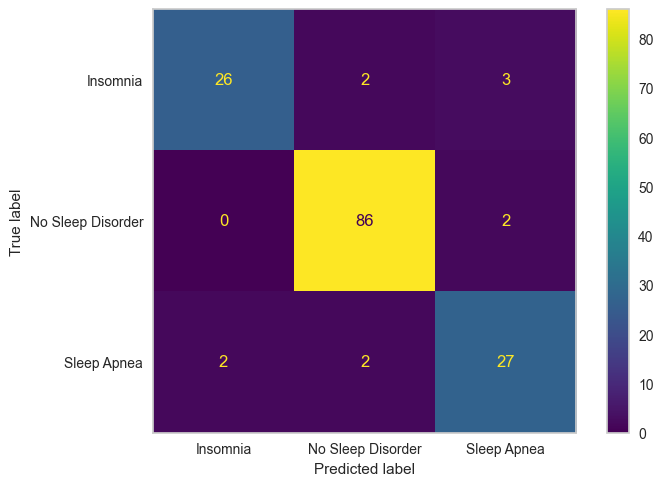

In [43]:
ConfusionMatrixDisplay.from_estimator(
    model_stacked_tuned, 
    X_test_transformed, 
    y_test_transformed, 
    display_labels=s.pipeline['label_encoding'].inverse_transform(model_stacked_tuned.classes_)
)
plt.grid(visible=False);

## Pycaret Summary

In [80]:
average = 'weighted'
baseline_wt_f1 = f1_score(y_test, baseline.predict(X_test), average=average)
tuned_wt_f1 = f1_score(y_test, rscv.best_estimator_.predict(X_test), average=average)
model_1_tuned_wt_f1 = f1_score(y_test_transformed, model_1_tuned.predict(X_test_transformed), average=average)
model_2_tuned_wt_f1 = f1_score(y_test_transformed, model_2_tuned.predict(X_test_transformed), average=average)
model_3_tuned_wt_f1 = f1_score(y_test_transformed, model_3_tuned.predict(X_test_transformed), average=average)
model_stacked_tuned_wt_f1 = f1_score(y_test_transformed, model_stacked_tuned.predict(X_test_transformed), average=average)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [81]:
summary_df = pd.DataFrame(
    {
        'Logistic Regression Base': [
            baseline['model'].get_params(),
            baseline_accuracy,
            baseline_wt_f1
        ],
        'Logistic Regression Tuned': [
            rscv.best_estimator_['model'].get_params(),
            tuned_accuracy,
            tuned_wt_f1
        ],
        'Pycaret Model 1 Tuned': [
            model_1_tuned.get_params(),
            model_1_tuned_accuracy,
            model_1_tuned_wt_f1
        ],
        'Pycaret Model 2 Tuned': [
            model_2_tuned.get_params(),
            model_2_tuned_accuracy,
            model_2_tuned_wt_f1
        ],
        'Pycaret Model 3 Tuned': [
            model_3_tuned.get_params(),
            model_3_tuned_accuracy,
            model_3_tuned_wt_f1
        ],
        'Pycaret Model Stacked Tuned': [
            model_stacked_tuned.get_params(),
            model_stacked_tuned_accuracy,
            model_stacked_tuned_wt_f1
        ],
    },
    index=['hyperparameters', 'accuracy', 'weighted f1']
)

summary_df

,Logistic Regression Base,Logistic Regression Tuned,Pycaret Model 1 Tuned,Pycaret Model 2 Tuned,Pycaret Model 3 Tuned,Pycaret Model Stacked Tuned
hyperparameters,"{'C': 1.0, 'class_weight': None, 'dual': False...","{'C': 0.31489116479568624, 'class_weight': Non...","{'boosting_type': 'gbdt', 'class_weight': None...","{'alpha': 6.78, 'class_weight': None, 'copy_X'...","{'objective': 'multi:softprob', 'base_score': ...","{'cv': 5, 'estimators': [('Light Gradient Boos..."
accuracy,0.926667,0.926667,0.9,0.893333,0.933333,0.926667
weighted f1,0.926804,0.926833,0.898127,0.894519,0.932891,0.926181


In [82]:
summary_df.to_csv('summary.csv')

Based from the table, tuned Model 3 (CatBoost Classifier) turned out to be the best model with accuracy of 93.33% and weighted f1 score of 93.29%.

In [83]:
best_model = model_3_tuned
best_model.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 290,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 1,
 'reg_lambda': 0.0005,
 'sampling_method': None,
 'scale_pos_weight': 31.400000000000006,
 'subsample': 0.3,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

# Best Model Summary

## Pipeline

In [84]:
s.pipeline

Pipeline(memory=FastMemory(location=C:\Users\Deomary\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('rare_category_grouping',
                 TransformerWrapper(exclude=None,
                                    include=['Gender', 'Occupation',
                                             'BMI Category'],
                                    transformer=RareCategoryGrouping(rare_to_value=0.02,
                                                                     valu...
                                                              handle_missing='return_nan',
                                                              handle_unknown='value',
                                                              return_df=True,
                                                              use_cat_names=True,
                                                              verbose=0))),
                ('normalize',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=StandardScaler(copy=True,
                                                               with_mean=True,
                                                               with_std=True))),
                ('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+')))],
         verbose=False)

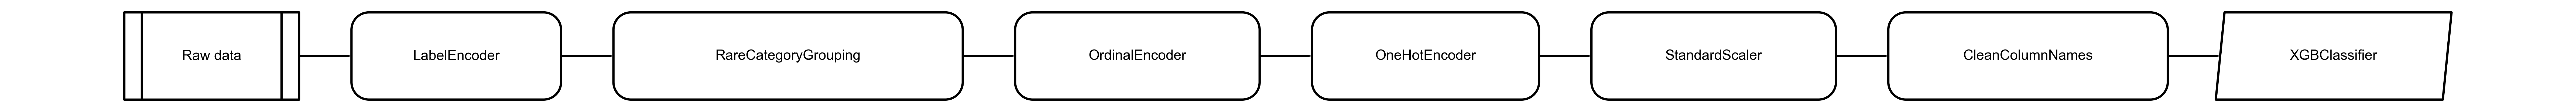

In [85]:
s.plot_model(best_model, 'pipeline', scale=3)

## Model Hyperparameters

In [86]:
s.plot_model(best_model, 'parameter')

,Parameters
objective,multi:softprob
base_score,None
booster,gbtree
callbacks,None
colsample_bylevel,None
colsample_bynode,None
colsample_bytree,0.9
device,cpu
early_stopping_rounds,None
enable_categorical,False


## Confusion Matrix

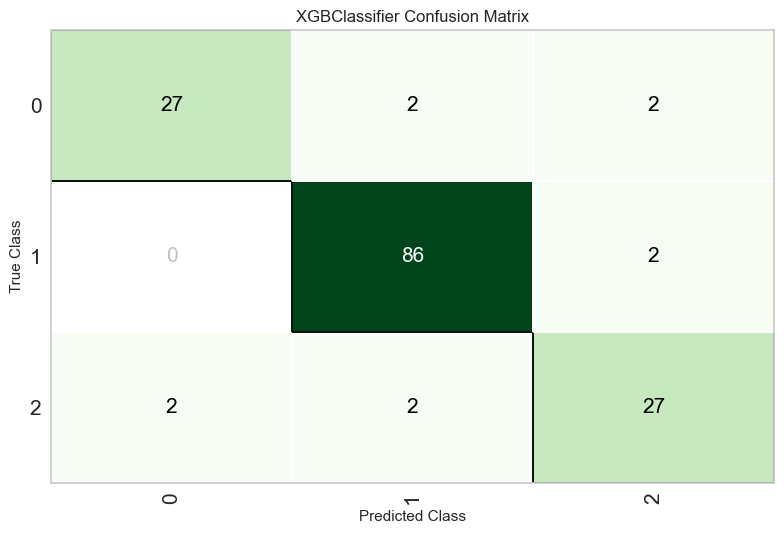

In [87]:
s.plot_model(best_model, 'confusion_matrix')

## Feature Importance

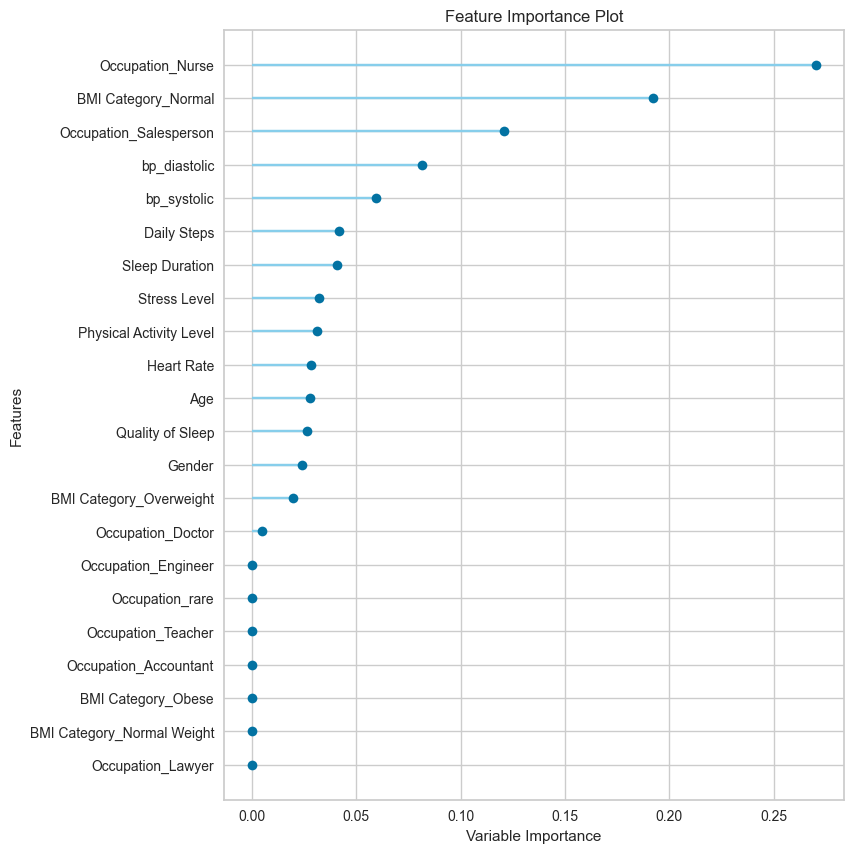

In [88]:
s.plot_model(best_model, 'feature_all')

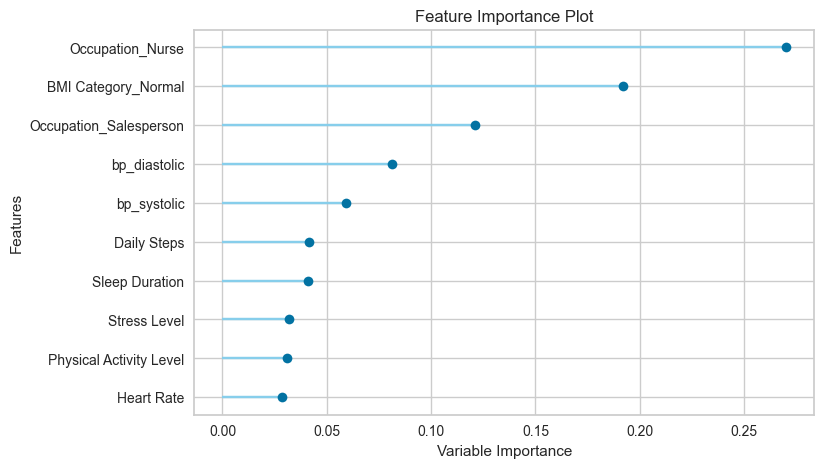

In [89]:
s.plot_model(best_model, 'feature')

## Decision Boundary

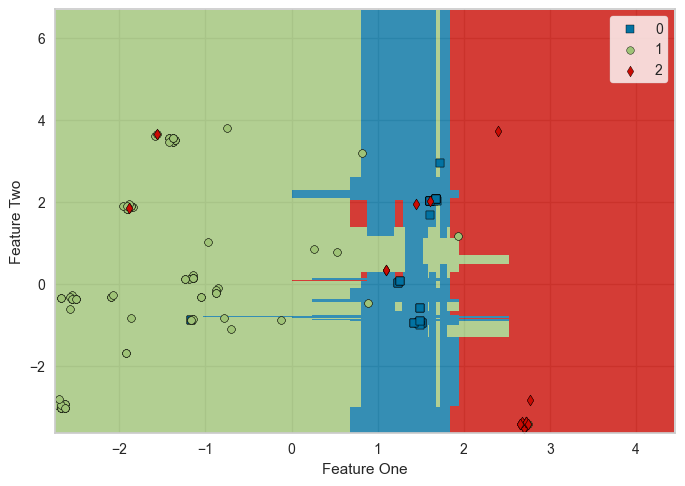

In [90]:
s.plot_model(best_model, 'boundary')

## SHAP (SHapley Additive exPlanations)

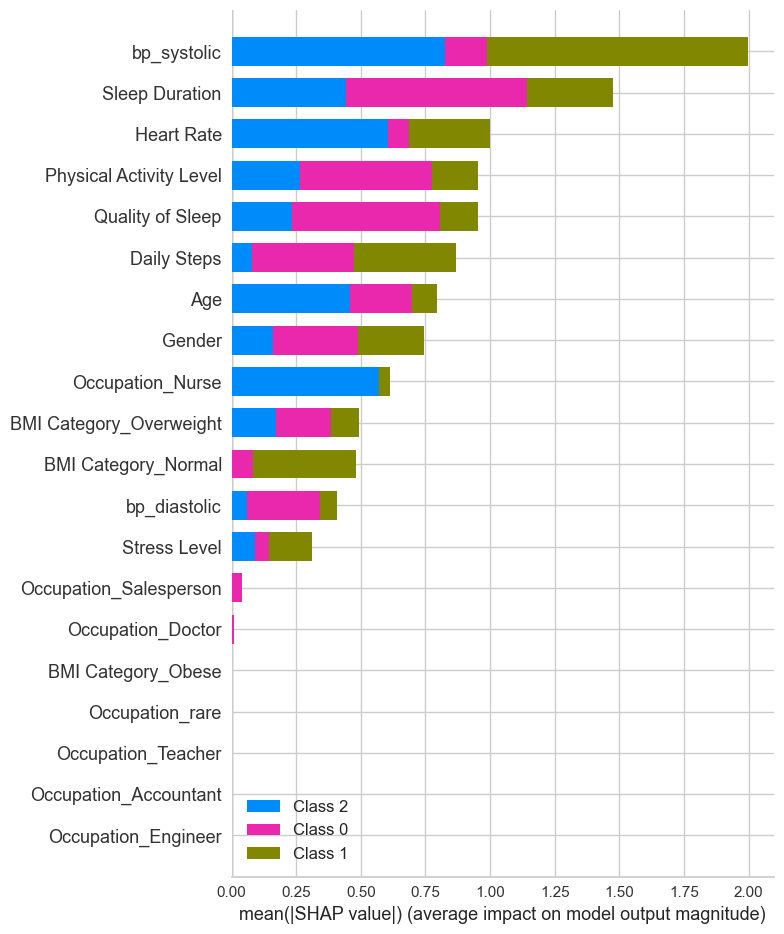

In [91]:
s.interpret_model(best_model, plot='summary')

# Pycaret Clustering

In [92]:
c = ClusteringExperiment()
c.setup(
    X, 
    session_id=42,
    imputation_type=None,
    normalize=True,
)

,Description,Value
0,Session id,42
1,Original data shape,"(374, 12)"
2,Transformed data shape,"(374, 25)"
3,Numeric features,9
4,Categorical features,3
5,Preprocess,True
6,Imputation type,None
7,Maximum one-hot encoding,-1
8,Encoding method,None
9,Normalize,True


8 is the selected number of clusters as based on the elbow plot.

In [93]:
clusterer = c.create_model('kmodes', num_clusters=8)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3729,51.5150,1.5844,0,0,0


## Elbow Plot

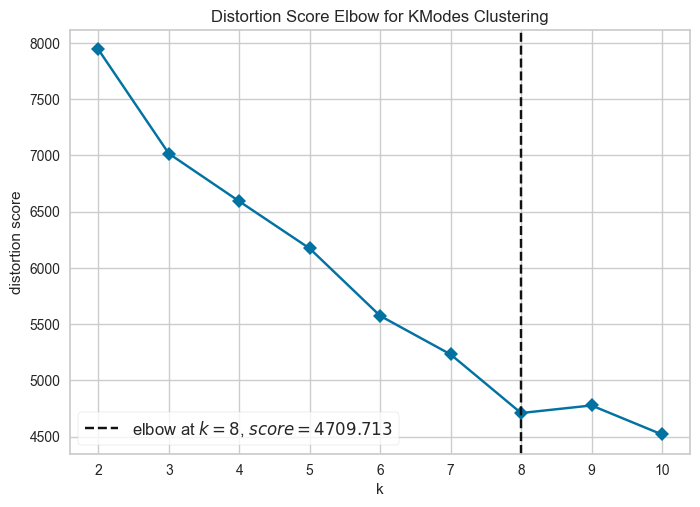

In [94]:
c.plot_model(clusterer, 'elbow')

## Pipeline

In [95]:
c.pipeline

Pipeline(memory=FastMemory(location=C:\Users\Deomary\AppData\Local\Temp\joblib),
         steps=[('ordinal_encoding',
                 TransformerWrapper(exclude=None, include=['Gender'],
                                    transformer=OrdinalEncoder(cols=['Gender'],
                                                               drop_invariant=False,
                                                               handle_missing='return_nan',
                                                               handle_unknown='value',
                                                               mapping=[{'col': 'Gender',
                                                                         'data_type': dtype('O'),
                                                                         'mapping': Female    0
Male      1
NaN      -1
dt...
                                    include=['Occupation', 'BMI Category'],
                                    transformer=OneHotEncoder(cols=['Occupation',
                                                                    'BMI '
                                                                    'Category'],
                                                              drop_invariant=False,
                                                              handle_missing='return_nan',
                                                              handle_unknown='value',
                                                              return_df=True,
                                                              use_cat_names=True,
                                                              verbose=0))),
                ('normalize',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=StandardScaler(copy=True,
                                                               with_mean=True,
                                                               with_std=True)))],
         verbose=False)

In [96]:
c.evaluate_model(clusterer)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## 2D Cluster Plot

In [97]:
c.plot_model(clusterer, 'cluster')

## Distribution

In [98]:
c.plot_model(clusterer, 'distribution')

## Silhouette

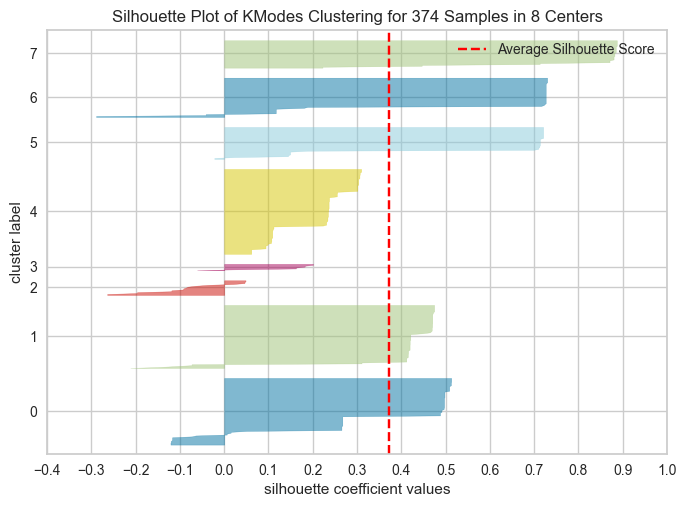

In [99]:
c.plot_model(clusterer, 'silhouette')

## Original Data appended with Cluster

In [100]:
clustered_df = c.assign_model(clusterer)
clustered_labeled_df = pd.concat([clustered_df, y], axis=1)
clustered_labeled_df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,bp_systolic,bp_diastolic,Cluster,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,126,83,Cluster 1,No Sleep Disorder
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,125,80,Cluster 4,No Sleep Disorder
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,125,80,Cluster 4,No Sleep Disorder
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,140,90,Cluster 3,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,140,90,Cluster 3,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,140,95,Cluster 1,Sleep Apnea
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,140,95,Cluster 1,Sleep Apnea
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,140,95,Cluster 1,Sleep Apnea
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,140,95,Cluster 1,Sleep Apnea


## Distribution per Cluster

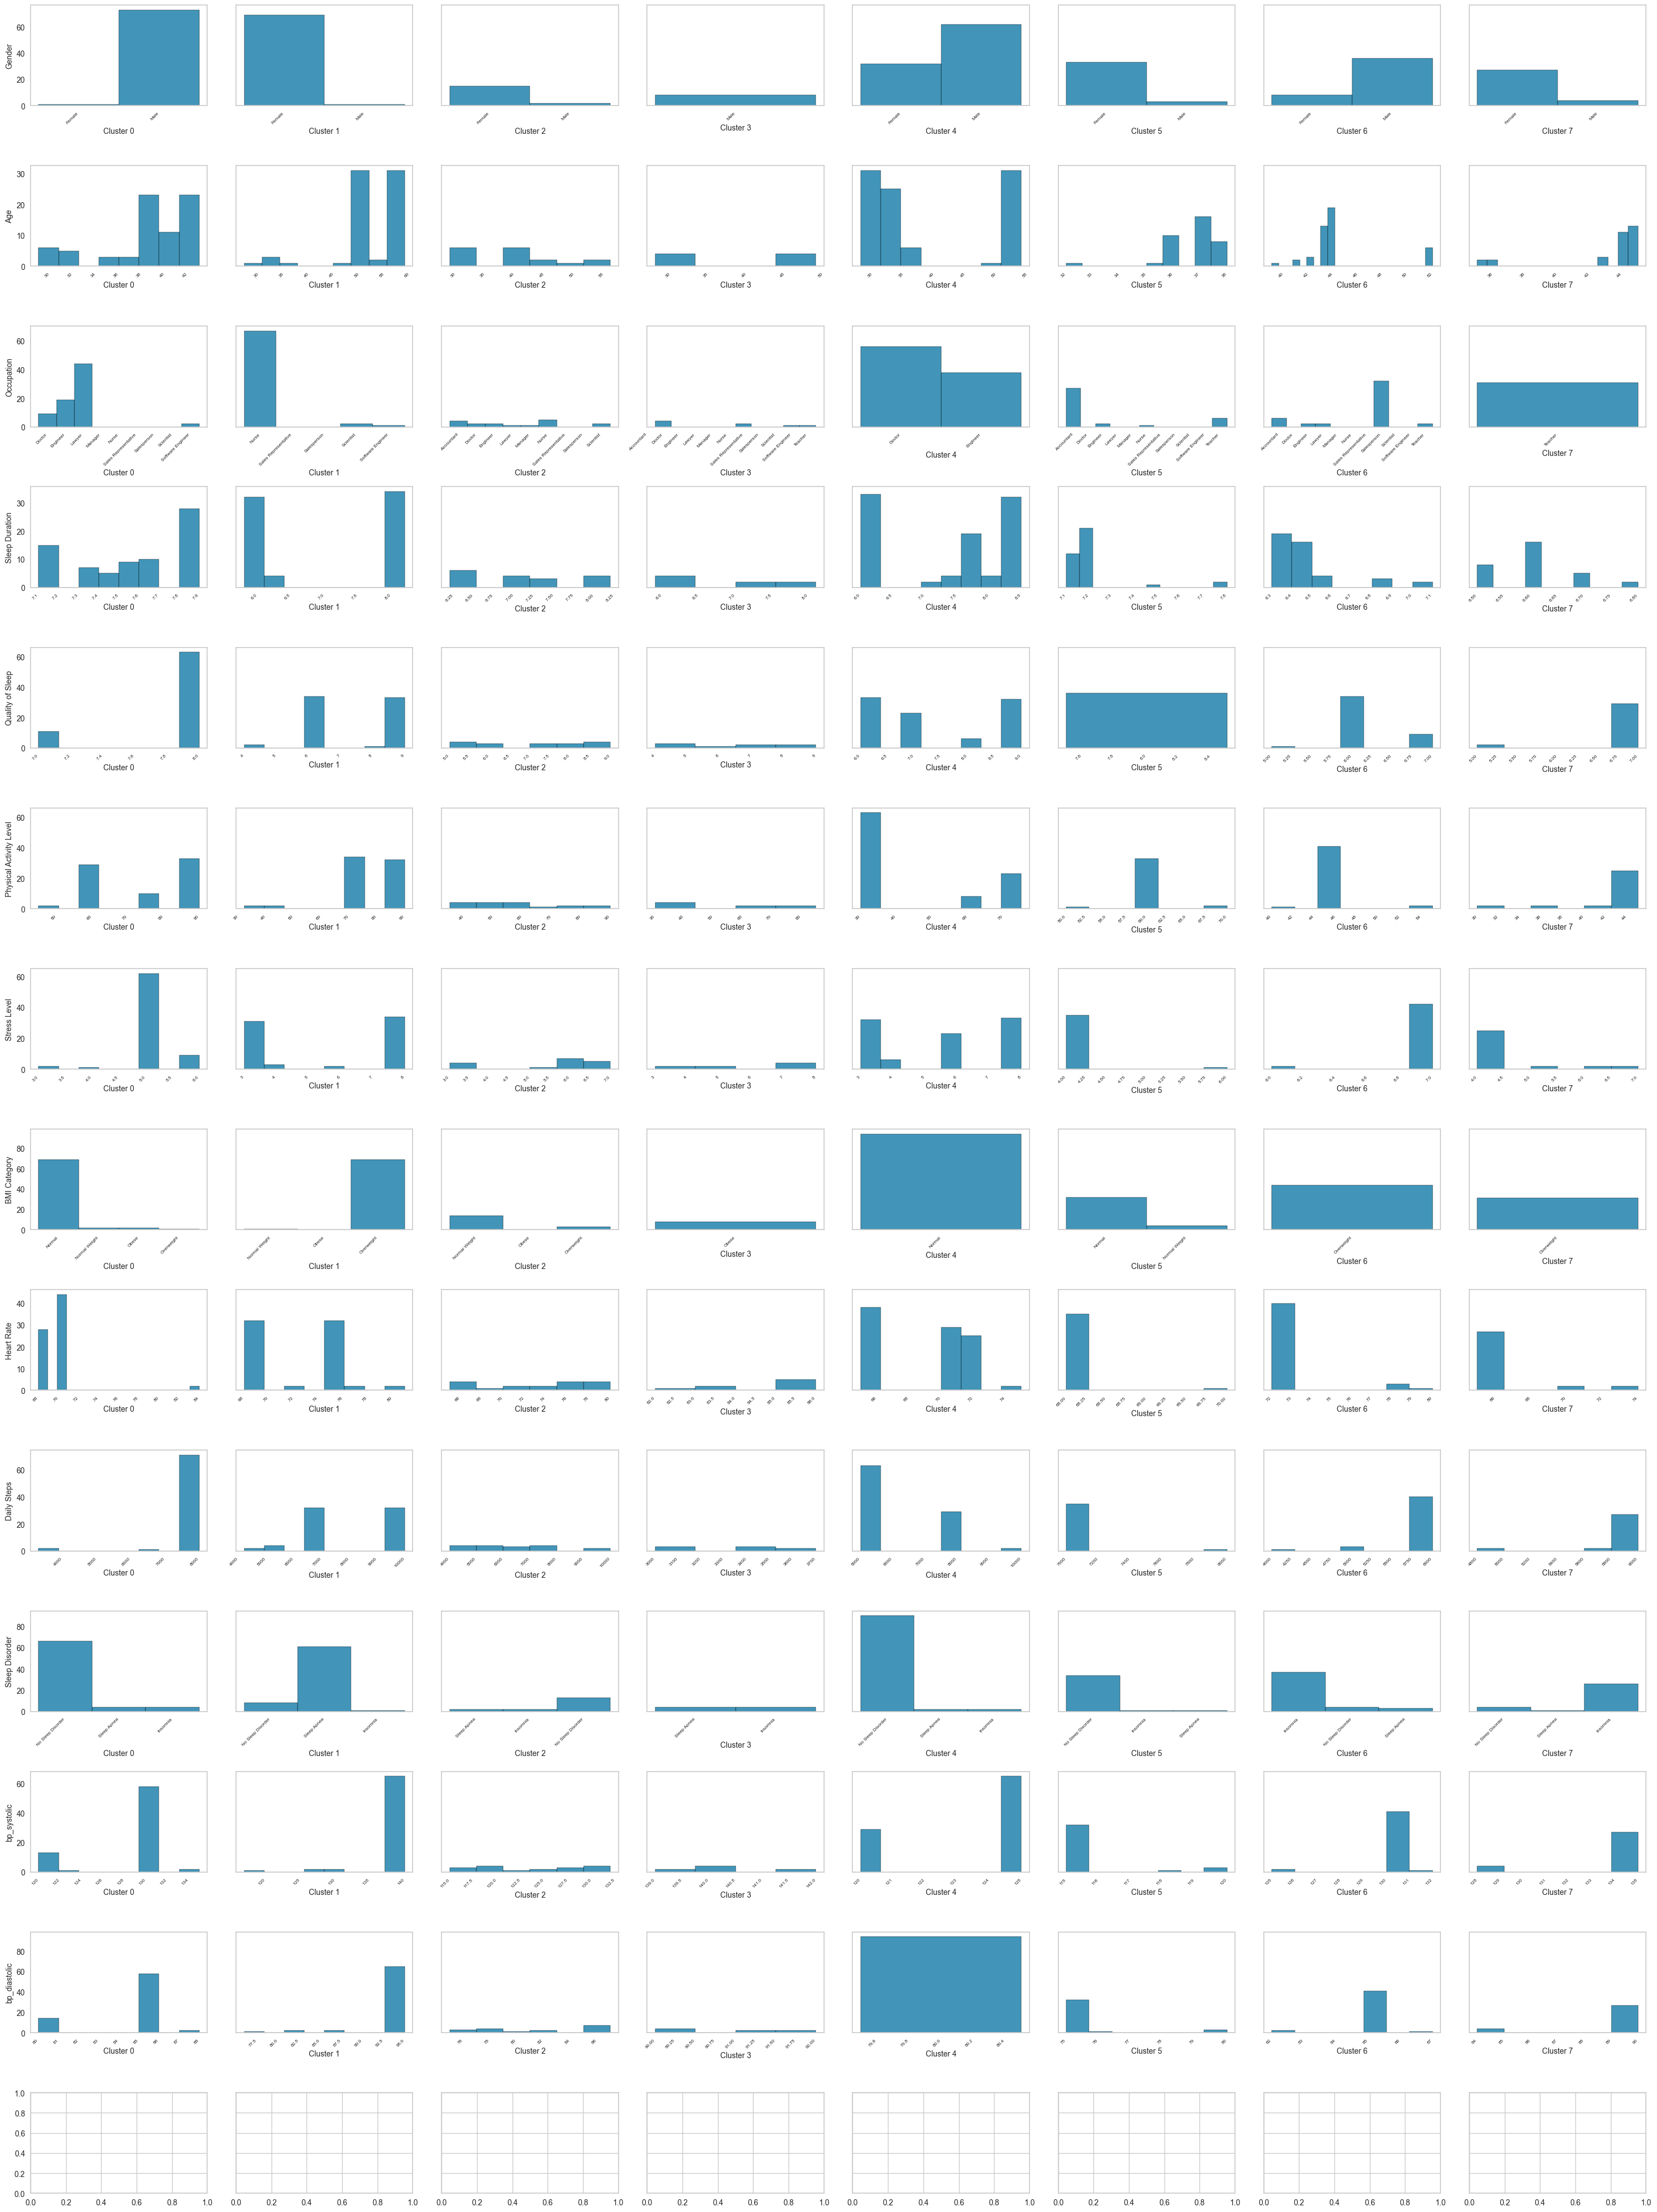

In [101]:
clusters = sorted(clustered_labeled_df['Cluster'].unique().tolist())
dataframes = [clustered_labeled_df[clustered_labeled_df['Cluster'] == x] for x in clusters]

x, axes = plt.subplots(nrows=len(clustered_labeled_df.columns), ncols=8, figsize=(30, 40), sharey='row')
axes = axes.flatten()
col_multiplied = np.array([[x, x, x, x, x, x, x, x] for x in df.columns]).reshape(-1)
for col, (index, ax)in zip(col_multiplied, enumerate(axes)):

    if (index + 1) % 8 == 1:
        df_use = dataframes[0]
        name = clusters[0]
    if (index + 1) % 8 == 2:
        df_use = dataframes[1]
        name = clusters[1]
    if (index + 1) % 8 == 3:
        df_use = dataframes[2]
        name = clusters[2]
    if (index + 1) % 8 == 4:
        df_use = dataframes[3]
        name = clusters[3]

    if (index + 1) % 8 == 5:
        df_use = dataframes[4]
        name = clusters[4]
    if (index + 1) % 8 == 6:
        df_use = dataframes[5]
        name = clusters[5]
    if (index + 1) % 8 == 7:
        df_use = dataframes[6]
        name = clusters[6]
    if (index + 1) % 8 == 0:
        df_use = dataframes[7]
        name = clusters[7]


    if (df_use[col].dtype == 'int64') or (df_use[col].dtype == 'float64'):
        bins = 20
    else:
        bins = 'auto'

    sns.histplot(df_use, x=col, ax=ax, bins=bins)
    ax.set_ylabel(col, fontsize=10)
    ax.set_xlabel(name, fontsize=10)
    ax.tick_params(axis='x', labelrotation=45, labelsize=6)
    ax.grid(False)

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')



plt.tight_layout()  

In [102]:
onehotencoder2 = ColumnTransformer(
    [
        (
            'onehotencoder', 
            OneHotEncoder(
                handle_unknown='infrequent_if_exist', 
                sparse_output=False,
                min_frequency=0.02
            ), 
            [col for col in df.columns if df[col].dtype == 'object']
        ),
    ],
    remainder='passthrough'
).set_output(transform='pandas')

In [103]:
cluster_summary = pd.concat(
    [
        StandardScaler().set_output(transform='pandas').fit_transform(onehotencoder2.fit_transform(df)), 
        clustered_df['Cluster']
    ], 
    axis=1
).groupby('Cluster').mean().T

cluster_summary.to_csv('cluster_summary.csv')
cluster_summary

Cluster,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7
onehotencoder__Gender_Female,-0.962333,0.982180,0.775445,-0.989361,-0.308471,0.844077,-0.625704,0.752674
onehotencoder__Gender_Male,0.962333,-0.982180,-0.775445,0.989361,0.308471,-0.844077,0.625704,-0.752674
onehotencoder__Occupation_Accountant,-0.331349,-0.331349,0.456725,-0.331349,-0.331349,2.180636,0.125375,-0.331349
onehotencoder__Occupation_Doctor,-0.173948,-0.484070,-0.184083,0.790874,1.035013,-0.484070,-0.484070,-0.484070
onehotencoder__Occupation_Engineer,0.235949,-0.450080,-0.135739,-0.450080,0.630052,-0.301641,-0.328630,-0.450080
onehotencoder__Occupation_Lawyer,1.414664,-0.379119,-0.201659,-0.379119,-0.379119,-0.379119,-0.241991,-0.379119
onehotencoder__Occupation_Nurse,-0.492468,1.922457,0.249607,-0.492468,-0.492468,-0.422383,-0.492468,-0.492468
onehotencoder__Occupation_Salesperson,-0.305888,-0.305888,-0.305888,-0.305888,-0.305888,-0.305888,2.294157,-0.305888
onehotencoder__Occupation_Teacher,-0.346064,-0.346064,-0.346064,0.058398,-0.346064,0.193219,-0.198987,2.889637
onehotencoder__Occupation_infrequent_sklearn,-0.014114,0.079578,0.870388,2.045412,-0.174078,-0.174078,-0.174078,-0.174078


For summarized version of the characteristics of different clusters, see **cluster_summary.csv.**